In [1]:
import pandas as pd
import matplotlib.pyplot as plt #grafik ve görsellestirme
from sklearn.model_selection import train_test_split #test ve eğitim verilerini bölmek için
from sklearn.neighbors import KNeighborsClassifier #knn modeli sınıfı
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import numpy as np
# Karar ağacını görselleştirme (opsiyonel)
from sklearn.tree import plot_tree

In [2]:
df=pd.read_csv('cleaned_data.csv')  

In [3]:
# 2. Hedef Değişkeni ve Özelliklerin Seçilmesi
X = df.drop(columns=["treatment"])  # Özellikler
y = df["treatment"]  # Hedef değişken


# 4. Eğitim ve Test Setlerine Bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Özellik Sıralaması:
                              Özellik  Etkinlik
7              work_interfere_encoded  0.200404
0                                 age  0.104743
2                      family_history  0.076574
6                     country_encoded  0.055782
8                no_employees_encoded  0.055044
10               care_options_encoded  0.048837
9                    benefits_encoded  0.044096
14                      leave_encoded  0.043354
17                  coworkers_encoded  0.037449
18                 supervisor_encoded  0.035838
15  mental_health_consequence_encoded  0.035216
20      phys_health_interview_encoded  0.035031
21         mental_vs_physical_encoded  0.032347
13                  anonymity_encoded  0.031205
12                  seek_help_encoded  0.027085
5                 gender_standardized  0.025612
16    phys_health_consequence_encoded  0.024517
11           wellness_program_encoded  0.021932
3                         remote_work  0.021082
19    mental_health_

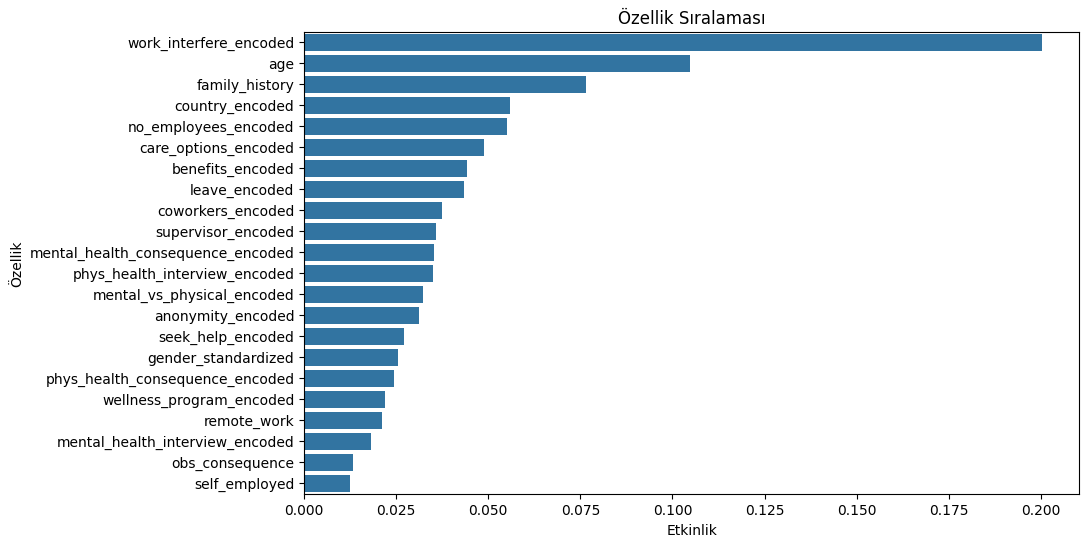

In [4]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest modelini oluşturma
rf_model = RandomForestClassifier(random_state=42)

# Modeli eğitme
rf_model.fit(X_train, y_train)

# Özellik sıralamasını alın
feature_importances = rf_model.feature_importances_

# Her bir özelliği etkinliğine göre sıralama
feature_importance_df = pd.DataFrame({
    'Özellik': X.columns,
    'Etkinlik': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Etkinlik', ascending=False)

# Özellik sıralamasını yazdırma
print("Özellik Sıralaması:")
print(feature_importance_df)

# Özellik sıralamasını görselleştirme
plt.figure(figsize=(10, 6))
sns.barplot(x='Etkinlik', y='Özellik', data=feature_importance_df)
plt.title('Özellik Sıralaması')
plt.show()

Seçilen Özellikler:
Index(['age', 'family_history', 'country_encoded', 'work_interfere_encoded',
       'no_employees_encoded', 'benefits_encoded', 'care_options_encoded',
       'anonymity_encoded', 'leave_encoded',
       'mental_health_consequence_encoded', 'coworkers_encoded',
       'supervisor_encoded', 'phys_health_interview_encoded',
       'mental_vs_physical_encoded'],
      dtype='object')
       Metrik     Değer
0    Doğruluk  0.834437
1  Hassasiyet  0.849462
2  Duyarlılık  0.877778
3    F1 Skoru  0.863388


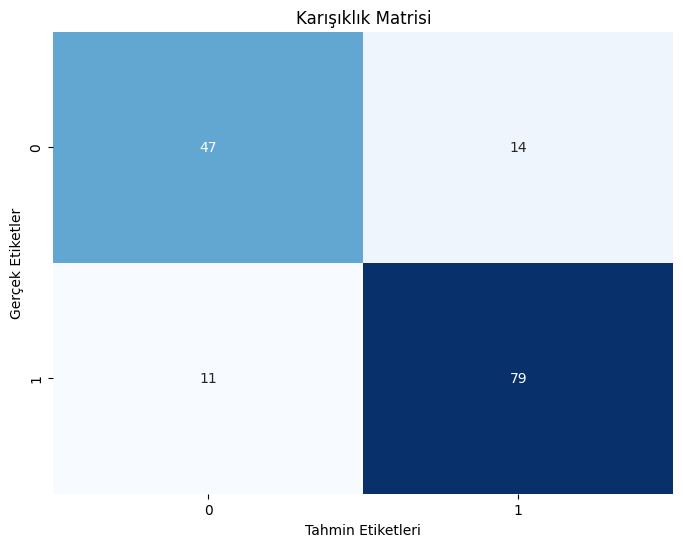

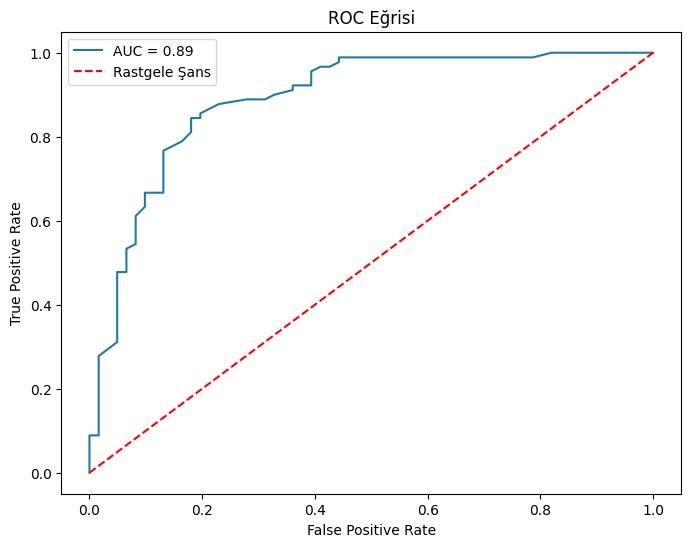

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.feature_selection import SelectFromModel
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Özellik seçimi yapalım (belirli bir önem eşiği ile)
sfm = SelectFromModel(rf_model, threshold=0.03)
sfm.fit(X_train, y_train)

# Seçilen özellikleri alalım
selected_features = X_train.columns[sfm.get_support()]

# Minimum seçilen özellik sayısını belirle
min_selected_features = 1

# Seçilen özelliklerin sayısını kontrol et
if selected_features.shape[0] < min_selected_features:
    raise ValueError(f"SelectFromModel tarafından seçilen özellik sayısı {min_selected_features}'den küçük. "
                     "Eğitim için yeterli özellik bulunamadı.")

# Modeli sadece seçilen özelliklerle tekrar eğitelim
rf_model_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_selected.fit(X_train[selected_features], y_train)

# Test seti üzerinde tahmin yapalım
X_test_selected = X_test[selected_features]
y_pred = rf_model_selected.predict(X_test_selected)


print("Seçilen Özellikler:")
print(selected_features)     

# Test seti üzerinde modelin performansını değerlendirelim
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Performans metriklerini içeren bir veri çerçevesi oluşturma
performans_tablosu = pd.DataFrame({
    'Metrik': ['Doğruluk', 'Hassasiyet', 'Duyarlılık', 'F1 Skoru'],
    'Değer': [accuracy, precision, recall, f1]
})

# Tabloyu yazdırma
print(performans_tablosu)

# Karışıklık matrisini görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Karışıklık Matrisi')
plt.xlabel('Tahmin Etiketleri')
plt.ylabel('Gerçek Etiketler')
plt.show()

# Modelin ROC eğrisini çıkarma
y_probs = rf_model_selected.predict_proba(X_test_selected)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# AUC-ROC skorunu hesaplama
auc_roc = roc_auc_score(y_test, y_probs)

# ROC eğrisini görselleştirme
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_roc:.2f}')
plt.plot([0, 1], [0, 1], 'r--', label='Rastgele Şans')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi')
plt.legend()
plt.show()